1. Urban 변수에 따른 Sales의 차이가 있는지를 통계적으로 검증하기 위한 통계분석을 수행하고, 결과를 해석하시오. (데이터는 정규성을 만족한다고 가정하고 유의수준 0.05하에서 검정)

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/Carseats.csv')
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


- 귀무가설 : Urban 변수에 따른 Sales의 평균에는 차이가 없다.
- 대립가설 : 차이가 존재한다.

In [2]:
df.Urban.value_counts()

Yes    282
No     118
Name: Urban, dtype: int64

In [3]:
import scipy.stats as stats
y_data = df[df['Urban'] == 'Yes']['Sales']
n_data = df[df['Urban'] == 'No']['Sales']
stats.f_oneway(y_data, n_data)

F_onewayResult(statistic=0.09465065557659712, pvalue=0.7585069603942085)

p-value가 0.05보다 크기 때문에 귀무가설을 채택하여 두 집단의 평균의 차이는 없다고 할 수 있다.

2. Sales변수와 Comprice, Income, Advertising, Population, Price, Age, Education 변수들 간에 피어슨 상관계수를 이용한 상관관계 분석을 수행하고 이를 해석하시오.

<AxesSubplot:>

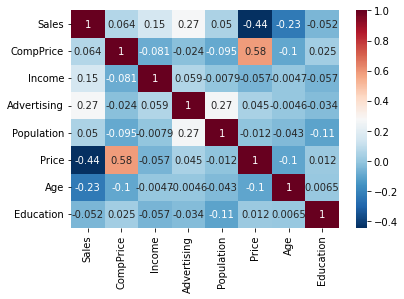

In [7]:
import seaborn as sns
df_corr = df.corr(method='pearson')
sns.heatmap(df_corr, cmap='RdBu_r', annot=True)

Sales 변수와 유의한 상관관계를 가진 변수는 없는 것으로 판단함

3. 종속변수를 Sales, 독립변수를 Comprice, Income, Adgertising, Population, Price, Age, Education으로 설정하고, 후진제거법을 활용하여 회귀분석을 실시하고 추정된 회귀식을 작성하시오.

In [10]:
import  statsmodels.api as sm

variables = ['CompPrice', 'Income', 'Advertising', 'Population', "Price", 'Age', 'Education']
y = df['Sales']

selected_variables = variables # 초기에는 모든 변수 선택
sl_remove = 0.05

sv_per_step = []
adjusted_r_squared = []
steps = []
step = 0

while len(selected_variables) > 0:
    X = sm.add_constant(df[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:]
    max_pval = p_vals.max()
    
    if max_pval >= sl_remove:
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
        
        step+=1
        steps.append(step)
        
        adj_r_squared = sm.OLS(y, sm.add_constant(df[selected_variables]))
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
        
    else:
        pass

In [ ]:
selected_variables